# Задача OneMax

OneMax (или One-Max) – это простая задача оптимизации, которую часто приводят в  пример как аналог программы «Hello World» в мире генетических алгоритмов. 

Задача OneMax состоит в том, чтобы найти двоичную строку заданной длины, для  которой сумма составляющих ее цифр максимальна. Например, при решении задачи OneMax длины 5 будут рассматриваться такие кандидаты:

*   10010 (сумма цифр = 2);
*   01110 (сумма цифр = 3);
*   11111 (сумма цифр = 5).


Очевидно, что решением всегда является строка, состоящая из одних единиц. Но генетический алгоритм не обладает таким знанием, поэтому должен слепо искать решение, пользуясь генетическими операторами. Если алгоритм справится с работой, то найдет решение (или приближение к нему) за разумное время.

## Выбор хромосомы
Поскольку в задаче OneMax мы имеем дело с двоичными строками, с выбором хромосом проблем не возникает – каждый индивидуум представлен двоичной строкой, которая непосредственно соответствует потенциальному решению. На языке Python это реализуется в виде списка, содержащего числа 0 или 1. Длина хромосомы совпадает с размером задачи OneMax. Например, в задаче OneMax размера 5 индивидуум 10010 будет представлен списком [1, 0, 0, 1, 0].

## Вычисление приспособленности
Поскольку мы хотим найти индивидуума с наибольшей суммой цифр, следует использовать стратегию *FitnessMax*. А поскольку каждый индивидуум представлен списком целых чисел, равных 0 или 1, то приспособленность вычисляется просто как сумма элементов списка, например: sum([1, 0, 0, 1, 0]) = 2.

## Выбор генетических операторов
Теперь нужно решить, какие реализации генетических операторов отбора, скрещивания и мутации использовать. В предыдущей главе мы рассмотрели несколько таких реализаций. Выбор конкретного оператора – не точная наука, обычно приходится экспериментировать. Но если операторы отбора обычно могут работать с хромосомами любого типа, то операторы скрещивания и мутации должны соответствовать типу хромосомы, иначе будут получаться недопустимые хромосомы.


В качестве **оператора отбора** можно для начала взять **турнир**, потому что его реализация проста и эффективна. Позже можно будет поэкспериментировать с другими стратегиями, например **правилом рулетки** и **SUS**.


Что касается **скрещивания,** то подойдет **одноточечный** или **двухточечный оператор**, поскольку в результате скрещивания двух двоичных строк этими
методами получается допустимая двоичная строка.


В качестве операции **мутации** можно взять простое **инвертирование бита**, этот метод хорошо работает для двоичных строк.

## Задание условия остановки
Всегда имеет смысл ограничивать количество поколений, чтобы алгоритм не работал вечно. Тем самым мы получаем **одно условие остановки**.

Кроме того, так уж получилось, что мы знаем наилучшее решение в задаче OneMax – двоичная строка из одних единиц со значением приспособленности, равным количеству единиц, – поэтому можно взять это в качестве **второго условия остановки.** 


---


*(Отметим, что в реальной задаче такая априорная информация обычно неизвестна.)*

---



Если хотя бы одно условие выполнено – достигнут предел количества поколений или найдено наилучшее решение, то алгоритм останавливается.

Теперь перейдем к непосредственному решению задачи.

# Подготовка

In [1]:
# Импортируем необходимые модули из DEAP и еще несколько вспомогательных библиотек:

from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Объявляем несколько констант, содержащих значения параметров самой задачи и генетического алгоритма:

# константы задачи
ONE_MAX_LENGTH = 100 # длина подлежащей оптимизации битовой строки

# константы генетического алгоритма
POPULATION_SIZE = 200 # количество индивидуумов в популяции
P_CROSSOVER = 0.9 # вероятность скрещивания
P_MUTATION = 0.1 # вероятность мутации индивидуума
MAX_GENERATIONS = 50 # максимальное количество поколений

Важный аспект генетического алгоритма – его вероятностный характер, поэтому в алгоритм нужно внести элемент случайности. Однако на этапе экспериментирования требуется, чтобы результаты были воспроизводимы. Для этого мы задаем какое-нибудь фиксированное начальное значение генератора случайных чисел:

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#Впоследствии эти строки нужно будет удалить, чтобы при разных прогонах получались разные результаты.

Воспользуемся классом *Toolbox*, чтобы определить оператор *zeroOrOne* путем специализации функции random.randomint(a, b). Эта функция возвращает случайное целое число N такое, что a ≤ N ≤ b. Если задать в качестве a и b фиксированные значения 0 и 1, то оператор *zeroOrOne* будет случайным образом возвращать 0 или 1. Во фрагменте ниже мы определяем переменную *toolbox*, а затем используем ее для регистрации оператора *zeroOrOne*:

In [4]:
toolbox = base.Toolbox()
toolbox.register("zeroOrOne", random.randint, 0, 1)

Далее следует создать класс *Fitness*. Поскольку у нас всего одна цель – сумма цифр, а наша задача – максимизировать ее, то выбираем стратегию *FitnessMax*, задав в кортеже *weights* всего один положительный вес:

In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

По соглашению, в *DEAP* для представления индивидуумов используется класс с именем *Individual*, для создания которого применяется модуль *creator*. В нашем случае базовым классом является *list*, т. е. хромосома представляется списком. Дополнительно в класс добавляется атрибут *fitness*, инициализируемый экземпляром определенного ранее класса *FitnessMax*:


In [6]:
creator.create("Individual", list, fitness=creator.FitnessMax)

Далее зарегистрируем оператор *individualCreator*, который создает экземпляр класса *Individual*, заполненный случайными значениями 0 или 1. Для этого мы настроим ранее определенный оператор *zeroOrOne*. В качестве базового класса используется вышеупомянутый оператор *initRepeat*, специализированный
следующими аргументами:

*   класс *Individual* в качестве типа контейнера, в который помещаются созданные объекты;
*   оператор *zeroOrOne* в качестве функции генерации объектов;
*   константа *ONE_MAX_LENGTH* в качестве количества генерируемых объектов.

Поскольку оператор *zeroOrOne* создает объекты, принимающие случайное значение 0 или 1, то получающийся в результате оператор *individualCreator*
заполняет экземпляр *Individual* 100 случайными значениями
0 или 1:

In [7]:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

Регистрируем оператор *populationCreator*, создающий список индивидуумов. В его определении также используется оператор *initRepeat* со следующими аргументами:

*   класс *list* в качестве типа контейнера;
*   оператор *individualCreator*, определенный ранее в качестве функции, генерирующей объекты в списке.

In [8]:
#Последний аргумент initRepeat – количество генерируемых объектов – здесь не задан. Это означает, что при использовании оператора populationCreator
#мы должны будем указать этот аргумент, т. е. задать размер популяции:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

Для вычисления приспособленности мы сначала определим свободную функцию, которая принимает экземпляр класса *Individual* и возвращает его приспособленность. В данном случае мы назвали функцию, вычисляющую количество единиц в индивидууме, *oneMaxFitness*. Поскольку индивидуум представляет собой не что иное, как список значений 0 и 1, то на поставленный вопрос в точности отвечает встроенная функция *Python* *sum()*:

In [9]:
def oneMaxFitness(individual):
  return sum(individual), # вернуть кортеж

#значения приспособленности в DEAP представлены кортежами, поэтому если возвращается всего одно значение, то после него нужно поставить запятую.

Теперь определим оператор *evaluate* – псевдоним только что определенной функции *oneMaxfitness()*. Ниже мы узнаем, что использование псевдонима *evaluate* для вычисления приспособленности – принятое в DEAP соглашение:

In [10]:
toolbox.register("evaluate", oneMaxFitness)

Генетические операторы обычно создаются как псевдонимы существующих функций из модуля *tools* с конкретными значениями аргументов. В данном случае
аргументы будут такими:

*   турнирный отбор с размером турнира 3;
*   одноточечное скрещивание;
*   мутация инвертированием бита.

Обратите внимание на параметр *indpb* функции *mutFlipBit*.
Эта функция обходит все атрибуты индивидуума – в нашем случае список
значений 0 и 1 – и для каждого атрибута использует значение данного
аргумента как вероятность инвертирования (применения логического оператора НЕ)
значения атрибута.
Это значение не зависит от вероятности мутации,
которая задается константой *P_MUTATION*, – мы определили ее выше,
но пока не использовали.
Вероятность мутации нужна при решении о том, вызывать
ли функцию mutFlipBit для данного индивидуума в популяции:

In [11]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)

# Эволюция решения

Реализуем Генетический алгоритм в функции main() и поясним его шаги ниже.

In [12]:
def main():

  #Создаем начальную популяцию оператором populationCreator, задавая размер популяции POPULATION_SIZE. Также инициализируем переменную generationCounter, которая понадобится нам позже:
  population = toolbox.populationCreator(n=POPULATION_SIZE)
  generationCounter = 0

  #Для вычисления приспособленности каждого индивидуума в начальной популяции воспользуемся функцией map(), которая применяет оператор evaluate к каждому элементу популяции.
  #Поскольку оператор evaluate – это псевдоним функции oneMaxFitness(), получающийся итерируемый объект содержит вычисленные значения приспособленности каждого индивидуума. 
  fitnessValues = list(map(toolbox.evaluate, population))

  # Поскольку элементы списка fitnessValues взаимно однозначно соответствуют элементам популяции (представляющей собой список индивидуумов), мы можем воспользоваться функцией zip(), чтобы
  # объединить их попарно, сопоставив каждому индивидууму его приспособленность:
  for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

  #Далее, так как в нашем случае имеет место приспособляемость всего с одной целью, то извлекаем первое значение из каждого кортежа приспособленности для сбора статистики:
  fitnessValues = [individual.fitness.values[0] for individual in population]

  #В качестве статистики мы собираем максимальное и среднее значение приспособленности в каждом поколении. Для этого нам понадобятся два списка:
  maxFitnessValues = []
  meanFitnessValues = []

  #Напишем главный цикл алгоритма. В самом начале цикла проверяются условия остановки. Одно из них – ограничение на количество поколений,
  #второе – проверка на лучшее возможное решение (двоичная строка из одних единиц), после чего обновляется счетчик количества поколений:
  while max(fitnessValues) < ONE_MAX_LENGTH and generationCounter < MAX_GENERATIONS:
    generationCounter = generationCounter + 1

    #Далее применим – генетические операторы. Сначала – оператор отбора toolbox.select, который был определен как турнирный отбор.
    #Поскольку размер турнира был задан в определении оператора, сейчас нам осталось передать только популяцию и ее размер:
    offspring = toolbox.select(population, len(population))

    #Далее отобранные индивидуумы, которые находятся в списке offspring, клонируются, чтобы можно было применить к ним следующие генетические операторы, не затрагивая исходную популяцию:
    offspring = list(map(toolbox.clone, offspring))

    #Следующий генетический оператор – скрещивание. Ранее мы определили его в атрибуте toolbox.mate как псевдоним одноточечного скрещивания.
    #Мы воспользуемся встроенной в Python операцией среза, чтобы объединить в пары каждый элемент списка offspring с четным индексом со следующим за ним элементом с нечетным индексом.
    #Затем с помощью функции random() мы «подбросим монету» с вероятностью, заданной константой P_CROSSOVER, и тем самым решим, применять к паре индивидуумов скрещивание или оставить их так.
    #После удалим значения приспособленности потомков, потому что они были модифицированы и старые значения уже не актуальны:
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < P_CROSSOVER:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
        #функция mate принимает двух индивидуумов и модифицирует их на месте, т. е. присваивать им новые значения не нужно.

    #Последний генетический оператор – мутация, ранее мы определили его в атрибуте toolbox.mutate как псевдоним инвертирования бита.
    #Мы должны обойти всех потомков и применить оператор мутации с вероятностью P_MUTATION.
    #Если индивидуум подвергся мутации, то нужно удалить значение его приспособленности (если оно существует), поскольку оно могло быть перенесено из предыдущего поколения:
    for mutant in offspring:
      if random.random() < P_MUTATION:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    #Те индивидуумы, к которым не применялось ни скрещивание, ни мутация, остались неизменными, поэтому их приспособленности, вычисленные в предыдущем поколении, не нужно заново пересчитывать.
    #В остальных индивидуумах значение приспособленности будет пустым. Мы находим этих индивидуумов, проверяя свойство valid класса Fitness, после чего вычисляем новое значение приспособленности:
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
      individual.fitness.values = fitnessValue

    #После того как все генетические операторы применены, нужно заменить старую популяцию новой:
    population[:] = offspring

    #Прежде чем переходить к следующей итерации, учтем в статистике текущие значения приспособленности.
    #Поскольку приспособленность представлена кортежем (из одного элемента), необходимо указать индекс [0]:
    fitnessValues = [ind.fitness.values[0] for ind in population]

    #Далее мы вычисляем максимальное и среднее значения, помещаем их в накопители и печатаем сводную информацию:
    maxFitness = max(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print("- Поколение {}: Макс приспособ. = {}, Средняя приспособ. = {}".format(generationCounter, maxFitness, meanFitness))

    #Дополнительно мы находим индекс (первого) лучшего индивидуума, пользуясь только что найденным значением приспособленности, и распечатываем этого индивидуума:
    best_index = fitnessValues.index(max(fitnessValues))
    print("Лучший индивидуум = ", *population[best_index], "\n")

  #После срабатывания условий остановки накопители статистики можно использовать для построения двух графиков с помощью библиотеки matplotlib.
  #Во фрагменте кода ниже рисуется график изменения лучшей и средней приспособленности:
  plt.plot(maxFitnessValues, color='red')
  plt.plot(meanFitnessValues, color='green')
  plt.xlabel('Поколение')
  plt.ylabel('Макс/средняя приспособленность')
  plt.title('Зависимость максимальной и средней приспособленности от поколения')
  plt.show()

- Поколение 1: Макс приспособ. = 65.0, Средняя приспособ. = 53.575
Лучший индивидуум =  1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 56.855
Лучший индивидуум =  1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

- Поколение 3: Макс приспособ. = 69.0, Средняя приспособ. = 59.42
Лучший индивидуум =  1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 

- Поколение 4: Макс приспособ. = 70.0, Средняя приспособ. = 62.03
Лучший индивидуум =  1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 

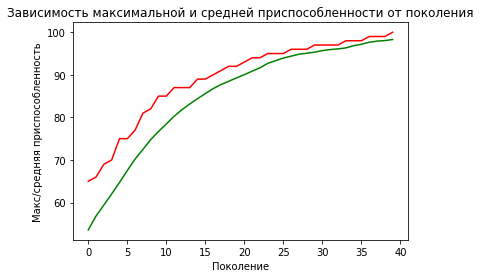

In [13]:
main()

В результате работы программы должно получиться, что после смены 40 поколений находится решение, содержащее только единицы, для которого приспособленность равна 100. После этого алгоритм останавливается. Начальное значение средней приспособленности равняется примерно 53, конечное – 100.

График должен отразить, что максимальная приспособленность возрастает скачкоообразно, а средняя – плавно.

# Ответ на решение задачи

- Поколение 1: Макс приспособ. = 66.0, Средняя приспособ. = 53.6075
Лучший индивидуум =  0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 

- Поколение 2: Макс приспособ. = 67.0, Средняя приспособ. = 57.08
Лучший индивидуум =  1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 

- Поколение 3: Макс приспособ. = 68.0, Средняя приспособ. = 60.4625
Лучший индивидуум =  1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 

- Поколение 4: Макс приспособ. = 70.0, Средняя приспособ. = 63.295
Лучший индивидуум =  1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1

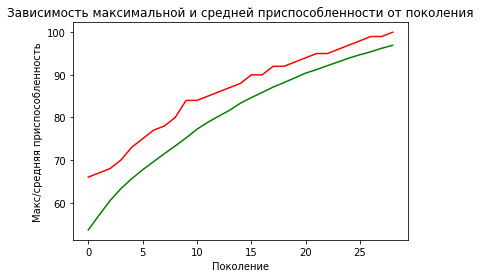

In [14]:
POPULATION_SIZE = 400
MAX_GENERATIONS = 50
main()

- Поколение 1: Макс приспособ. = 66.0, Средняя приспособ. = 55.13
Лучший индивидуум =  0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 

- Поколение 2: Макс приспособ. = 67.0, Средняя приспособ. = 58.64
Лучший индивидуум =  1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 

- Поколение 3: Макс приспособ. = 67.0, Средняя приспособ. = 61.78
Лучший индивидуум =  0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 

- Поколение 4: Макс приспособ. = 71.0, Средняя приспособ. = 64.37
Лучший индивидуум =  0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 

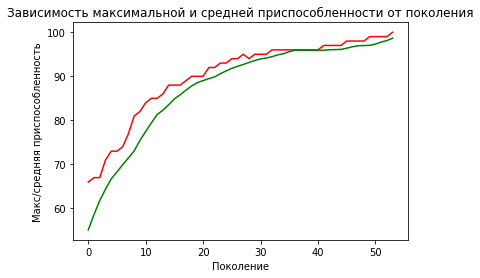

In [15]:
POPULATION_SIZE = 100
MAX_GENERATIONS = 80
main()

- Поколение 1: Макс приспособ. = 66.0, Средняя приспособ. = 54.58
Лучший индивидуум =  1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 57.925
Лучший индивидуум =  1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 

- Поколение 3: Макс приспособ. = 69.0, Средняя приспособ. = 61.5
Лучший индивидуум =  0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 

- Поколение 4: Макс приспособ. = 73.0, Средняя приспособ. = 64.125
Лучший индивидуум =  1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0

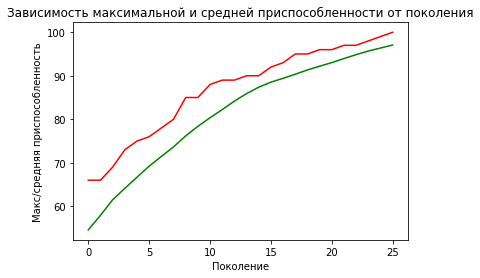

In [16]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 50
toolbox.register("mate", tools.cxTwoPoint)
main()

## Эксперименты с оператором мутации

### 1) При исходных гиперпараметрах увеличьте вероятность мутации до 0.9.

- Поколение 1: Макс приспособ. = 64.0, Средняя приспособ. = 54.285
Лучший индивидуум =  1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 57.46
Лучший индивидуум =  1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 

- Поколение 3: Макс приспособ. = 68.0, Средняя приспособ. = 60.36
Лучший индивидуум =  0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 

- Поколение 4: Макс приспособ. = 70.0, Средняя приспособ. = 62.73
Лучший индивидуум =  1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1

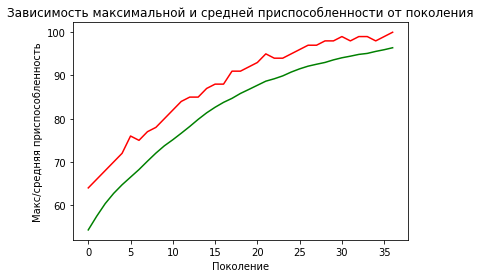

In [17]:
# Исходные гиперпараметры и оператор скрещивания
POPULATION_SIZE = 200
MAX_GENERATIONS = 50
toolbox.register("mate", tools.cxOnePoint)

# Вероятность мутации 90%
P_MUTATION = .9

main()

Алгоритм сходится к наилучшему решению достаточно быстро
(возможно чуть быстрее, чем при стандартных параметрах),
но среднее значение приспособленности сходится несколько медленнее, чем
при стандартных параметрах.


### 2) Увеличьте значение indpb в операторе мутации в 10 раз.

- Поколение 1: Макс приспособ. = 66.0, Средняя приспособ. = 54.135
Лучший индивидуум =  0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 

- Поколение 2: Макс приспособ. = 66.0, Средняя приспособ. = 56.57
Лучший индивидуум =  1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 

- Поколение 3: Макс приспособ. = 70.0, Средняя приспособ. = 58.15
Лучший индивидуум =  0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 

- Поколение 4: Макс приспособ. = 71.0, Средняя приспособ. = 59.86
Лучший индивидуум =  1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0

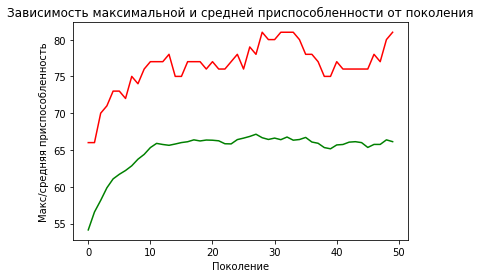

In [18]:
# Оставляем веротяность мутации P_MUTATION (вероятность того, что примениться функция ниже)
# и увеличиваем гиперпараметр indpb (вероятность инвертирования конкретного бита) в 10 раз
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH * 10)

main()

Алгоритм застревает на средней приспособленности примерно в 66 и дальше не развивается.

### 3) Увеличьте значение indpb в операторе мутации в 50 раз от исходного.

- Поколение 1: Макс приспособ. = 64.0, Средняя приспособ. = 50.855
Лучший индивидуум =  0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 

- Поколение 2: Макс приспособ. = 67.0, Средняя приспособ. = 50.83
Лучший индивидуум =  0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 

- Поколение 3: Макс приспособ. = 63.0, Средняя приспособ. = 50.62
Лучший индивидуум =  1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 

- Поколение 4: Макс приспособ. = 64.0, Средняя приспособ. = 50.235
Лучший индивидуум =  1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 

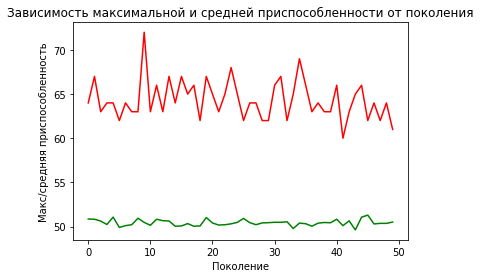

In [19]:
# Теперь увеличиваем indpb в 50 раз от исходного
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH * 50)

main()

Аналогично алгоритм застревает на средней приспособленности примерно в 62
и дальше не развивается из-за слишком сильной мутации.
Лучшие отобранные гены ввиду чрезмерной мутации становятся далеко не самыми лучшими.

## Эксперименты с оператором отбора

### 1) При исходных гиперпараметрах установите размер турнира равным 2.

- Поколение 1: Макс приспособ. = 65.0, Средняя приспособ. = 53.055
Лучший индивидуум =  0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 

- Поколение 2: Макс приспособ. = 65.0, Средняя приспособ. = 54.625
Лучший индивидуум =  0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 

- Поколение 3: Макс приспособ. = 66.0, Средняя приспособ. = 56.08
Лучший индивидуум =  0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 

- Поколение 4: Макс приспособ. = 69.0, Средняя приспособ. = 57.785
Лучший индивидуум =  0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1

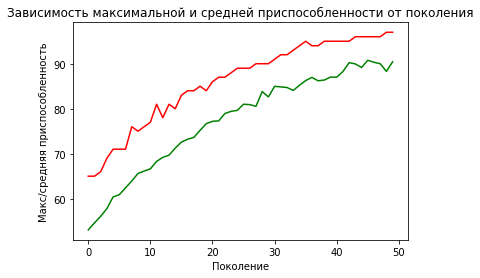

In [20]:
P_MUTATION = .1
toolbox.register("select", tools.selTournament, tournsize=2)
main()

При размере турнира равным 2 алгоритм сходится значительно медленнее. 

### 2) Теперь установите размер турнира равным 100.

- Поколение 1: Макс приспособ. = 64.0, Средняя приспособ. = 58.235
Лучший индивидуум =  1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 

- Поколение 2: Макс приспособ. = 72.0, Средняя приспособ. = 62.125
Лучший индивидуум =  1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 

- Поколение 3: Макс приспособ. = 74.0, Средняя приспособ. = 68.485
Лучший индивидуум =  1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 

- Поколение 4: Макс приспособ. = 74.0, Средняя приспособ. = 70.55
Лучший индивидуум =  1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1

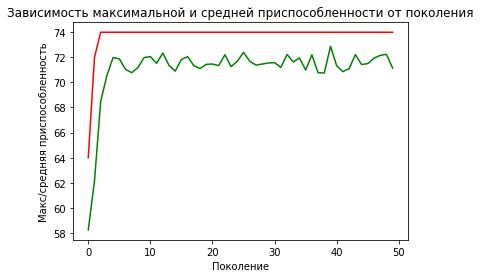

In [21]:
P_MUTATION = .1
toolbox.register("select", tools.selTournament, tournsize=100)
main()

А при размере турнира 100, что равно половине популяции, алгоритм вовсе 
перестаёт развиваться.

### 3) Не меняя другие параметры, уменьшите вероятность мутаций в 10 раз, а затем уменьшите еще в 10 раз.

- Поколение 1: Макс приспособ. = 70.0, Средняя приспособ. = 63.13
Лучший индивидуум =  1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 

- Поколение 2: Макс приспособ. = 74.0, Средняя приспособ. = 69.71
Лучший индивидуум =  1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 

- Поколение 3: Макс приспособ. = 77.0, Средняя приспособ. = 73.28
Лучший индивидуум =  1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 

- Поколение 4: Макс приспособ. = 79.0, Средняя приспособ. = 76.36
Лучший индивидуум =  1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 

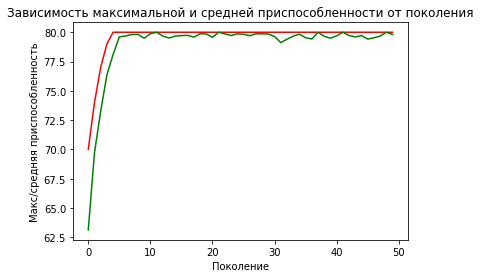

In [22]:
P_MUTATION = .01
main()

Ситуация аналогична предыдущей, но из-за уменьшенного шанса на мутацию индивидуумы
стали ещё больше похоже друг на друга, следовательно, средняя приспособленность 
приблизительно равна наилучшей.

- Поколение 1: Макс приспособ. = 65.0, Средняя приспособ. = 60.47
Лучший индивидуум =  0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 

- Поколение 2: Макс приспособ. = 69.0, Средняя приспособ. = 64.92
Лучший индивидуум =  0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 

- Поколение 3: Макс приспособ. = 73.0, Средняя приспособ. = 69.0
Лучший индивидуум =  1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 

- Поколение 4: Макс приспособ. = 76.0, Средняя приспособ. = 72.825
Лучший индивидуум =  1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 

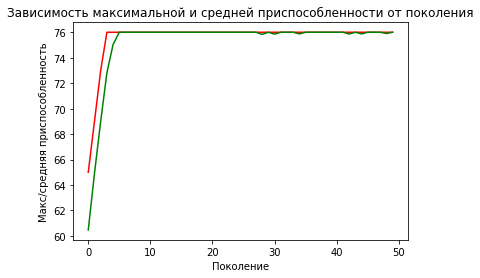

In [23]:
P_MUTATION = .001
main()

Ситуация полностью аналогична предыдущей, из-за ещё более уменьшенного шанса на мутацию
индивидуумы стали ещё больше похоже друг на друга, следовательно, средняя 
приспособленность уже равна или почти равна наилучшей.

### 4) Вернитесь к исходным параметрам алгоритма и замените турнирный отбор отбором по правилу рулетки.

- Поколение 1: Макс приспособ. = 63.0, Средняя приспособ. = 50.87
Лучший индивидуум =  1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 

- Поколение 2: Макс приспособ. = 65.0, Средняя приспособ. = 51.02
Лучший индивидуум =  1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 

- Поколение 3: Макс приспособ. = 66.0, Средняя приспособ. = 51.585
Лучший индивидуум =  1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 

- Поколение 4: Макс приспособ. = 65.0, Средняя приспособ. = 52.07
Лучший индивидуум =  1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1

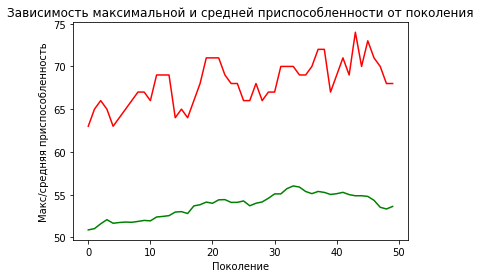

In [24]:
P_MUTATION = .1
toolbox.register("select", tools.selRoulette)
main()

При отборе по правилу рулетки алгоритм не сходится.
